<a href="https://colab.research.google.com/github/agomulka/SentimentAnalysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment analysis on tweets dataset**

> In my project I would like to experiment with the Twitter US Airline dataset which is available on the website *https://www.kaggle.com/crowdflower/twitter-airline-sentiment* and originally came from Crowdflower's Data for Everyone library.
My goal is to do sentiment analysis, predict if tweets are positive, negative or neutral about flight.


> Firstly we need to load into Colab two files: 
our dataset *Tweets.csv* and *glove.6B.100d.txt*, which will be needed later.




# 1. Import libraries

At the beginning we have to import necessary Python libraries.

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline   
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
import nltk 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from wordcloud import WordCloud

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import joblib

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 2. Loading dataset

In [ ]:
dataset = pd.read_csv('Tweets.csv')

In [ ]:
dataset.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [ ]:
dataset.shape

(14640, 15)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

The file contains 14640 rows and 15 columns. The included features are: 
* **tweet id** - unique number of tweet,
* **sentiment** - positive, negative or neutral
* **sentiment confidence score**, 
* **negative reason** - main reason for negative tweets, 
* **negative reason confidence**, 
* **airline** - name of airline company,
* **sentiment gold**, 
* **name** - user name, 
* **retweet count** - integer number how many times tweet was retweeted,
* **tweet text** - tweet message (string), 
* **tweet coordinates** - cooridinates of localization, 
* **time of tweet** - time posting tweet,
* **date of tweet** - date posting tweet, 
* **tweet location**, 
* **user time zone**.

# 3. Dataset analysis 

We are going to do basic analysis to better understand the data.

In [ ]:
100*dataset.isnull().sum()/len(dataset) 

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64

Airline_sentiment_gold, negativereason_gold and tweet_coord have more than 90% of missing values.



   * negative reason



In [ ]:
dataset.groupby(dataset['negativereason'].isnull())['airline_sentiment'].count()

negativereason
False    9178
True     5462
Name: airline_sentiment, dtype: int64

We have over 5400 missing values in *negative reason* feature.



In [ ]:
dataset['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

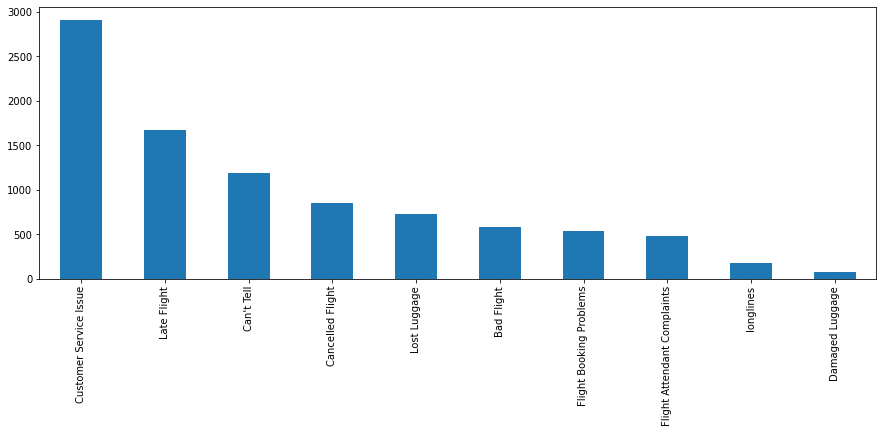

In [ ]:
dataset['negativereason'].value_counts().plot(kind='bar', figsize=(15,5))

The most popular reasons are: Customer Service Issue, Late Flight.

* airline

In [ ]:
dataset['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [ ]:
def pieChart(df):
    sizes = df.value_counts()
    labels = df.value_counts().index.values
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels = labels, autopct='%1.1f%%', startangle=90, counterclock=False)
    ax1.axis('equal')

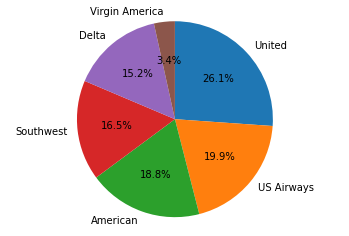

In [ ]:
pieChart(dataset['airline'])

In dataset we have over one quarter tweets about United company, almost 20% tweets about US Airways and American. Then, around 15% tweets are about Southwest and Delta airlines and, last but not least, we have tweets about Virgin America.

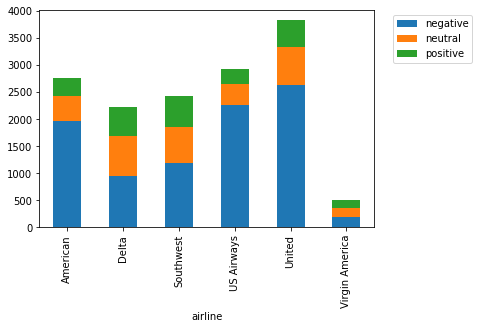

In [ ]:
dataset_gb = dataset.groupby(['airline', 'airline_sentiment']).size().unstack(level=1)
dataset_gb.plot(kind = 'bar',stacked=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

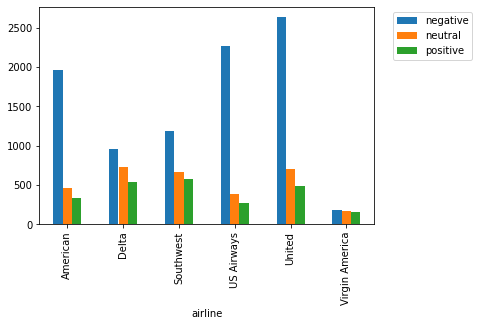

In [ ]:
dataset_gb.plot(kind = 'bar')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

It should be noted that for every airline company there is a lot of negative tweets.
Delta, Southwest and Virgin America have fairly balanced tweets.

* airline sentiment

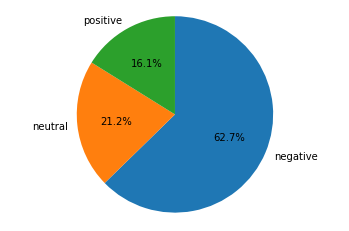

In [ ]:
pieChart(dataset['airline_sentiment'])

On this chart we can see that a majority of negative comments (63%) were followed by neutral (21%) and positive (16%).

* airline vs reason

In [ ]:
reason = dict(dataset['negativereason'].value_counts(sort=False))

In [ ]:
def count_reason(airline):
    if airline == 'all':
        df = dataset
    else:
        df = dataset[dataset['airline']==airline]
    airline_reason = dict(df['negativereason'].value_counts())
    unique_reason = list(dataset['negativereason'].unique())
    unique_reason = [x for x in unique_reason if str(x) != 'nan']
    reason_frame = pd.DataFrame({'reasons': unique_reason})
    reason_frame['count'] = reason_frame['reasons'].apply(lambda x : airline_reason[x])
    return reason_frame

In [ ]:
def plot_reason(airline):
    df = count_reason(airline)
    count = df['count']
    Index = range(1,len(df)+1)
    plt.bar(Index,count)
    plt.xticks(Index,df['reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+airline)   

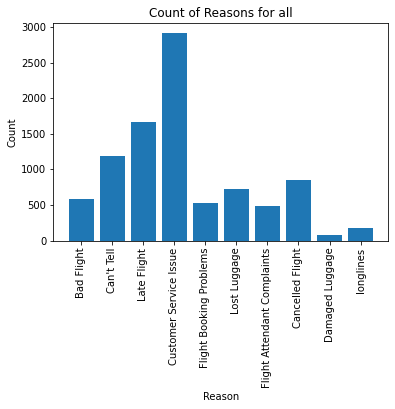

In [ ]:
plot_reason('all')

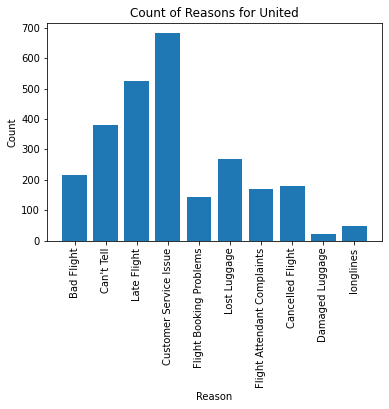

In [ ]:
plot_reason('United')

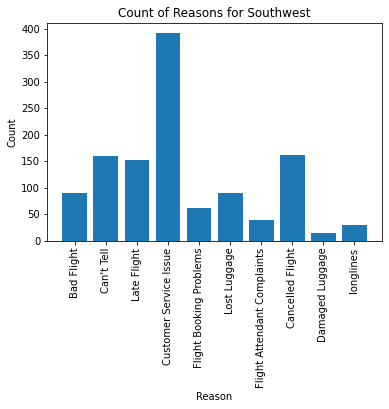

In [ ]:
plot_reason('Southwest')

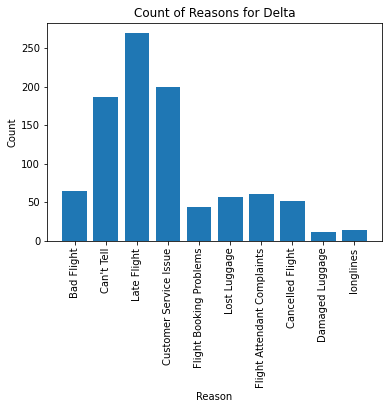

In [ ]:
plot_reason('Delta')

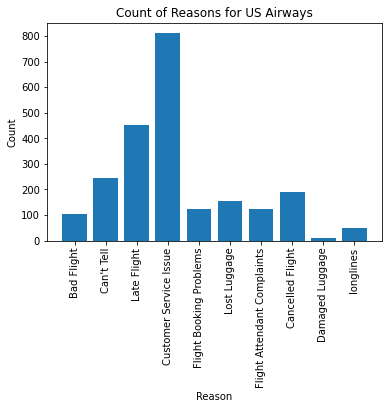

In [ ]:
plot_reason('US Airways') 

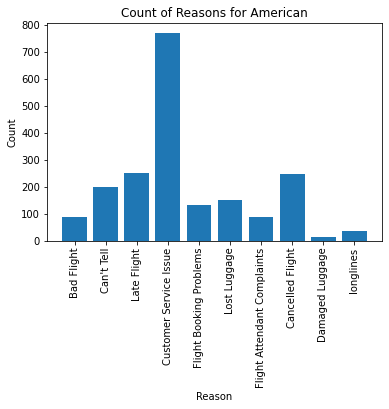

In [ ]:
plot_reason('American')

It should also be emphasized that the Customer Service Issue is the most popular reason for United, Southwest, US Airways and American companies.

# 4. Drop variables

In further work we need only 2 columns: text and sentiment.

In [ ]:
dataset.drop(['tweet_id', 'name','retweet_count', 'tweet_created', 'tweet_location',
       'user_timezone', 'airline_sentiment_confidence', 'negativereason','negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'], axis=1, inplace =True)

In [ ]:
dataset.to_csv('Tweets_cleaned.csv', index=False)

In [ ]:
dataset.columns

Index(['airline_sentiment', 'text'], dtype='object')

In [ ]:
dataset.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


# 5. Processing data

Before we start training models, we need to transforming text into a analyzable form.

In [ ]:
 pd.set_option('display.max_colwidth', -1) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [ ]:
dataset['text']

0        @VirginAmerica What @dhepburn said.                                                                                                                   
1        @VirginAmerica plus you've added commercials to the experience... tacky.                                                                              
2        @VirginAmerica I didn't today... Must mean I need to take another trip!                                                                               
3        @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse                        
4        @VirginAmerica and it's a really big bad thing about it                                                                                               
                                  ...                                                                                                                          
14635    @AmericanAir thank you we got o

First, we are going to remove stopwords - there are frequent words such as ”the”, ”is”, etc. We will be using a list of English stopwords from nltk library. It might take about 20 seconds.

In [ ]:
stopWords = stopwords.words('english')
stopWords.append('would')
stopWords.append("don't")

In [ ]:
dataset['text'] = dataset['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))
print('Stopwords removed')

Stopwords removed


Now we are going to processing using regular expression including convert all letters to lower case, remove numbers and punctuations.

In [ ]:
def preprocesing_text(text):  
    text = text.lower()    
    text = re.sub('https?://[A-Za-z0-9./]+', ' ', text)   #remove url links
    text = re.sub("www.[A-Za-z0-9./]+", ' ', text)      
    text = re.sub('@[^\s]+', ' ', text)     #remove user name
    text = re.sub('\d+', ' ', text)         #remove digits
    text = re.sub(r'[^\w\s]+', ' ', text)   #remove punctuations
    text = re.sub('_+', ' ', text)          #remove _ char
    text = re.sub('\n', ' ', text)          
    text = re.sub(r'\b\w{1,2}\b', '', text) #remove words < 2
    text = re.sub(' +', ' ', text)          #convert two or more spaces into one space
    return text

In [ ]:
dataset['text'] = dataset['text'].apply(preprocesing_text)

This is text after processing:

In [ ]:
dataset['text']

0         what said                                                                                             
1         plus added commercials experience tacky                                                               
2         today must mean need take another trip                                                                
3         really aggressive blast obnoxious entertainment guests faces amp little recourse                      
4         really big bad thing                                                                                  
                 ...                                                                                            
14635     thank got different flight chicago                                                                    
14636     leaving minutes late flight warnings communication minutes late flight that called shitty customer svc
14637     please bring american airlines blackberry                                             

* word cloud

Let's generate WordClouds which represent the frequency of each word at this moment.

In [ ]:
def wordCloud(sentiment):
    df = dataset[dataset['airline_sentiment'] == sentiment]
    textt = " ".join(review for review in df.text)
    wordcloud = WordCloud(stopwords = stopWords).generate(textt)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    wordcloud.to_file("wordCloud_"+sentiment+".png")

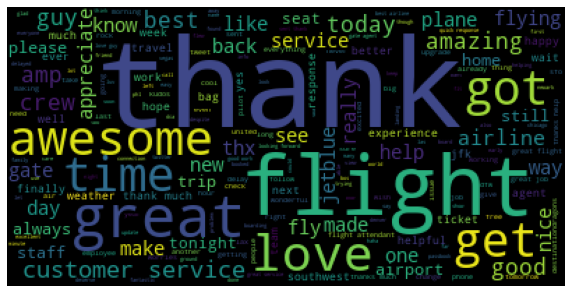

In [ ]:
wordCloud('positive')

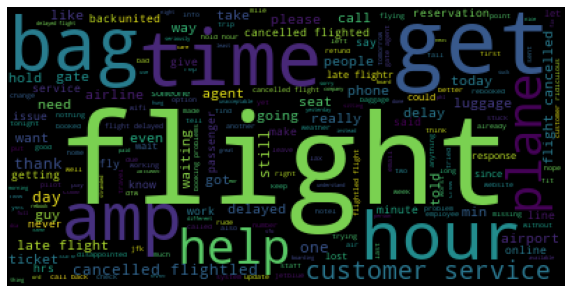

In [ ]:
wordCloud('negative')

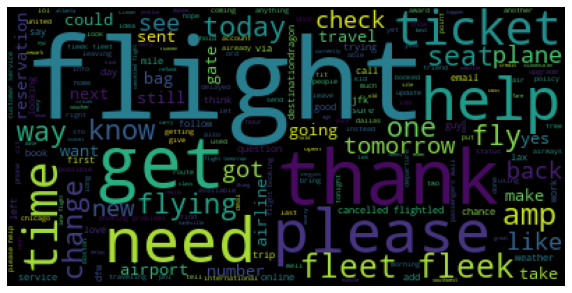

In [ ]:
wordCloud('neutral')

We can observe that words such as 'thank', 'great' and 'awesome' are present more frequently in positive statements. In negative statements there is 'time', 'hour', 'help'.

In [ ]:
dataset.to_csv('Tweets_processed.csv', index=False)

# 6. Split data

In [ ]:
dataset.shape

(14640, 2)

In [ ]:
X = dataset.drop('airline_sentiment', inplace=False, axis=1)
y = dataset['airline_sentiment']

* encode labels

We have to replace the categorical value with a numeric value in labels. 

In [ ]:
sentiment_num = {'negative' : 0,  'neutral': 1, 'positive': 2}

In [ ]:
y = y.map(sentiment_num)

In [ ]:
y

0        1
1        2
2        1
3        0
4        0
        ..
14635    2
14636    0
14637    1
14638    0
14639    1
Name: airline_sentiment, Length: 14640, dtype: int64

* split the data into train, validation, and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
print('training features size: '+str(X_train.shape)+", validation features size: "+ str(X_val.shape)+", testing features size: "+str(X_test.shape))
print('training labels size: '+str(y_train.shape)+", validation labels size: "+str(y_val.shape)+ ", testing labels size: "+str(y_test.shape))


training features size: (8784, 1), validation features size: (2928, 1), testing features size: (2928, 1)
training labels size: (8784,), validation labels size: (2928,), testing labels size: (2928,)


In [ ]:
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

* Vectorizer


Next we are going to transform text to feature vectors that can be used as input to estimator using TfidfVectorizer. It converts a collection of raw documents to a matrix of TF-IDF features.
> Term frequency-inverse document frequency (tf-idf) can be used to downweight those frequently occurring words in the feature vectors. It is a product of the term frequency and the inverse document frequency:

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$

> where the tf(t, d) — is the term frequency, the number of times a term t occurs in a document d and the inverse document frequency idf(t, d) can be calculated as:
$$\text{idf} (t,d) = log\frac{1 + n_d}{1 + \text{df}(d, t)}$$ 

> where $n_d$ is the total number of documents, and df(d, t) is the number of documents d that contain the term t.
> By default scikit-learn's TfidfTransformer applies the L2-normalization.

In [ ]:
vectoriser = TfidfVectorizer(decode_error='replace', encoding='utf-8')
train_matrix = vectoriser.fit_transform(X_train['text'].apply(lambda x: np.str_(x)))
val_matrix = vectoriser.transform(X_val['text'].apply(lambda x: np.str_(x)))
test_matrix = vectoriser.transform(X_test['text'].apply(lambda x: np.str_(x)))

In [ ]:
pd.DataFrame(train_matrix.toarray(), columns=vectoriser.get_feature_names())

,aaadvantage,aadavantage,aadelay,aadv,aadvantage,aafail,aal,aaron,abandon,abandoned,abandonment,abc,abcletjetbluestreamfeed,abcnews,abducted,abi,abilities,ability,able,aboard,aboout,abounds,about,abq,abroad,absolute,absolutely,absurd,absurdity,abt,abundance,abuse,abused,abysmal,acarl,acc,accept,acceptable,accepted,accepting,...,york,you,youareonyourown,youdidit,young,your,youragentshavenoclue,yourairlinesucks,youre,youredoingitwrong,youretheworst,yourock,yourphonesystemsucks,yours,yourself,yousuck,yout,youth,youve,yrs,ystrdy,yucki,yul,yuma,yup,yvonne,yvr,yyc,yyj,yyz,yyzua,zero,zfv,zip,zombie,zone,zones,zrh,zukes,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# print(vectoriser.get_feature_names())

# 7. Models

 At this time we apply various models to predict sentiments from tweet text data.

In [ ]:
def print_results(results):
    print('BEST {} WITH PARAMS: {}\n'.format(round(results.best_score_, 6), results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
accuracy_dict = {}

1. Logistic regression



We try to improve the model by tuning the hyperparameters like solvers and C-value which is inverse of regularization strength. It can takes about 5 minutes.

In [ ]:
model_lr = LogisticRegression()
solvers = ['newton-cg', 'lbfgs','liblinear']  
penalty = ['l2']
max_iter=[200]
c_values = [0.001, 0.01, 0.1, 1, 10, 100]

grid_lr = dict(solver=solvers, penalty=penalty, C=c_values, max_iter=max_iter)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
grid_search_lr = GridSearchCV(estimator=model_lr, param_grid=grid_lr, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result_lr = grid_search_lr.fit(train_matrix, y_train)
print_results(grid_result_lr)

BEST 0.7733 WITH PARAMS: {'C': 10, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}

0.627 (+/-0.001) for {'C': 0.001, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
0.627 (+/-0.001) for {'C': 0.001, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
0.627 (+/-0.001) for {'C': 0.001, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
0.627 (+/-0.001) for {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
0.627 (+/-0.001) for {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
0.627 (+/-0.001) for {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
0.682 (+/-0.017) for {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
0.682 (+/-0.017) for {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
0.665 (+/-0.015) for {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
0.769 (+/-0.022) for {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
0.768 (+/-0.022) for {

In [ ]:
accuracy_dict.update({'logistic regression': format(round(grid_result_lr.best_score_, 6))})

In [ ]:
joblib.dump(grid_result_lr.best_estimator_, 'LR_model.pkl')

['LR_model.pkl']

In [ ]:
model_lr = grid_result_lr.best_estimator_

2. Decision tree

In DecisionTreeClassifier we are going to tuning:
* max_depth - the maximum depth of the tree, 
* max_features - number of features at each split.
* min_samples_leaf - the minimum number of samples required to be at a leaf node.

In [ ]:
model_dt = DecisionTreeClassifier()
max_depth = [20, 75, None]
max_features =  [10, 20, 50, None]
min_samples_leaf = [8, 15, 20]

grid_dt = dict(max_depth=max_depth,  max_features=max_features, min_samples_leaf=min_samples_leaf)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=grid_dt, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result_dt = grid_search_dt.fit(train_matrix, y_train)
print_results(grid_result_dt)

BEST 0.700328 WITH PARAMS: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 8}

0.627 (+/-0.003) for {'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 8}
0.628 (+/-0.009) for {'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 15}
0.627 (+/-0.002) for {'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 20}
0.631 (+/-0.015) for {'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 8}
0.628 (+/-0.007) for {'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 15}
0.628 (+/-0.004) for {'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 20}
0.638 (+/-0.024) for {'max_depth': 20, 'max_features': 50, 'min_samples_leaf': 8}
0.637 (+/-0.024) for {'max_depth': 20, 'max_features': 50, 'min_samples_leaf': 15}
0.635 (+/-0.022) for {'max_depth': 20, 'max_features': 50, 'min_samples_leaf': 20}
0.688 (+/-0.015) for {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 8}
0.689 (+/-0.013) for {'max_depth': 20, 'max_features': None, 'min_samples_leaf'

In [ ]:
accuracy_dict.update({'decision tree': format(round(grid_result_dt.best_score_, 6))})

In [ ]:
joblib.dump(grid_result_dt.best_estimator_, 'DT_model.pkl')

['DT_model.pkl']

In [ ]:
model_dt = grid_result_dt.best_estimator_

3. Random Forest

Hyperparametrs in RandomForestClassifier:
* n-estimators - the number of trees in the forest.
* max_depth - the maximum depth of the tree.

It can takes about 10-15 minutes.

In [ ]:
model_rf = RandomForestClassifier()
n_estimators = [5,  100, 200]
max_depth = [16, 32, None] 

grid_rf = dict(n_estimators=n_estimators, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=grid_rf, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result_rf = grid_search_rf.fit(train_matrix, y_train)
print_results(grid_result_rf)

BEST 0.752999 WITH PARAMS: {'max_depth': None, 'n_estimators': 100}

0.639 (+/-0.014) for {'max_depth': 16, 'n_estimators': 5}
0.631 (+/-0.007) for {'max_depth': 16, 'n_estimators': 100}
0.63 (+/-0.004) for {'max_depth': 16, 'n_estimators': 200}
0.664 (+/-0.021) for {'max_depth': 32, 'n_estimators': 5}
0.663 (+/-0.016) for {'max_depth': 32, 'n_estimators': 100}
0.662 (+/-0.013) for {'max_depth': 32, 'n_estimators': 200}
0.717 (+/-0.028) for {'max_depth': None, 'n_estimators': 5}
0.753 (+/-0.023) for {'max_depth': None, 'n_estimators': 100}
0.753 (+/-0.022) for {'max_depth': None, 'n_estimators': 200}


In [ ]:
accuracy_dict.update({'Random Forest': format(round(grid_result_rf.best_score_, 6))})

In [ ]:
joblib.dump(grid_result_rf.best_estimator_, 'RF_model.pkl')

['RF_model.pkl']

In [ ]:
model_rf = grid_result_rf.best_estimator_

4. Support Vector Machine (SVM)

In Support Vector Machine we will examine the effect of changing kernel and C value to the model accuracy.

It can takes 10-15 minutes.

In [ ]:
model_svc = SVC()
kernel = ['linear', 'poly']
C = [0.1, 1]

grid_svc = dict(kernel=kernel,C=C)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
grid_search_svc = GridSearchCV(estimator=model_svc, param_grid=grid_svc, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result_svc = grid_search_svc.fit(train_matrix, y_train)
print_results(grid_result_svc)

BEST 0.773225 WITH PARAMS: {'C': 1, 'kernel': 'linear'}

0.681 (+/-0.014) for {'C': 0.1, 'kernel': 'linear'}
0.64 (+/-0.007) for {'C': 0.1, 'kernel': 'poly'}
0.773 (+/-0.021) for {'C': 1, 'kernel': 'linear'}
0.676 (+/-0.015) for {'C': 1, 'kernel': 'poly'}


In [ ]:
accuracy_dict.update({'SVM': format(round(grid_result_svc.best_score_, 6))})

In [ ]:
joblib.dump(grid_result_svc.best_estimator_, 'SVM_model.pkl')

['SVM_model.pkl']

In [ ]:
model_svc = grid_result_svc.best_estimator_

5. Naive Bayes

In Multinomial Naive Bayes we will tuning the alpha value.

In [ ]:
model_nb = MultinomialNB()
alpha = [ 0.001, 0.01, 0.1, 1, 1.5, 2.0]

grid_nb = dict(alpha = alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
grid_search_nb = GridSearchCV(estimator=model_nb, param_grid=grid_nb, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result_nb = grid_search_nb.fit(train_matrix, y_train)
print_results(grid_result_nb)

BEST 0.740969 WITH PARAMS: {'alpha': 0.1}

0.726 (+/-0.018) for {'alpha': 0.001}
0.733 (+/-0.017) for {'alpha': 0.01}
0.741 (+/-0.022) for {'alpha': 0.1}
0.684 (+/-0.012) for {'alpha': 1}
0.666 (+/-0.011) for {'alpha': 1.5}
0.657 (+/-0.009) for {'alpha': 2.0}


In [ ]:
accuracy_dict.update({'Multionmial NB': format(round(grid_result_nb.best_score_, 6))})

In [ ]:
joblib.dump(grid_result_nb.best_estimator_, 'NB_model.pkl')

['NB_model.pkl']

In [ ]:
model_nb = grid_result_nb.best_estimator_

6. Neural Network

To build neural network working with text data we need to transform our data differently.

We will be using Embedding Layer. 

First of all, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space.
Keras requires that the input data be integer encoded, so that each word is represented by a unique integer. This step can be performed using the Tokenizer API provided with Keras.

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:
* input_dim : this is the size of the vocabulary in the text data.
* output_dim : the size of the vector space in which words will be embedded. For example, it could be 32 or 100.
* input_length : the length of input sequences

Should be noted that the layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

In [ ]:
# create a copy of data to work with them
X_nn = X['text']
y_nn = y

In [ ]:
t = Tokenizer()
t.fit_on_texts(X_nn)

In [ ]:
# Find number of unique words in our tweets to estimate the vocabulary size
vocab_size = len(t.word_index) + 1
vocab_size

10876

In [ ]:
# integer encode everything
sequences = t.texts_to_sequences(X_nn)

In [ ]:
# Find longest tweet in sequences to have all inputs the same length
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [ ]:
tweet_num = max_tweet()
tweet_num

13

We will pad all input sequences to the same length with a Keras function, the pad_sequences().

In [ ]:
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

In [ ]:
padded_X.shape

(14640, 13)

In [ ]:
# Convert labels
labels = to_categorical(np.asarray(y_nn))

In [ ]:
labels

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(padded_X, labels, test_size = 0.4, random_state = 1)

In [ ]:
X_nn_val, X_nn_test, y_nn_val, y_nn_test = train_test_split(X_nn_test, y_nn_test, test_size=0.5, random_state=42)

In [ ]:
print('X_train size:', X_nn_train.shape)
print('y_train size:', y_nn_train.shape)
print('X_val size:', X_nn_val.shape)
print('y_val size:', y_nn_val.shape)
print('X_test size:', X_nn_test.shape)
print('y_test size:', y_nn_test.shape)

X_train size: (8784, 13)
y_train size: (8784, 3)
X_val size: (2928, 13)
y_val size: (2928, 3)
X_test size: (2928, 13)
y_test size: (2928, 3)


The Keras Embedding layer can also use a word embedding learned elsewhere.

For example, the researchers behind GloVe (Global Vectors for Word Representation) method provide a suite of pre-trained word embeddings on their website https://nlp.stanford.edu/projects/glove/

The smallest package of embeddings is “glove.6B.zip“. It was trained on a dataset of one billion tokens (words) with a vocabulary of 400 thousand words. 



In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


We will create an embedding matrix where each row number will correspond to the index of the word.

In [ ]:
# fill in matrix of embedding for each word in the training dataset.
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrixb
        embedding_matrix[i] = embedding_vector # each row of matrix

Now then, we can define our model.

We are not training our own embeddings and using the GloVe embedding, we set trainable to *False* and in the weights attribute we pass our own embedding matrix.

The Flatten layer will squash output 13x1000 matrix to 1300-element vector.

In [ ]:
model_nn = Sequential()
model_nn.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False))
model_nn.add(Flatten())
model_nn.add(Dense(10, activation='relu'))
model_nn.add(Dense(3, activation='softmax'))
model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 100)           1087600   
_________________________________________________________________
flatten (Flatten)            (None, 1300)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                13010     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 1,100,643
Trainable params: 13,043
Non-trainable params: 1,087,600
_________________________________________________________________


In [ ]:
history = model_nn.fit(X_nn_train, y_nn_train, epochs=100, batch_size=256, verbose = 1)

Epoch 1/100
35/35 [==============================] - 1s 3ms/step - loss: 0.8670 - acc: 0.6318
Epoch 2/100
35/35 [==============================] - 0s 3ms/step - loss: 0.7257 - acc: 0.6901
Epoch 3/100
35/35 [==============================] - 0s 3ms/step - loss: 0.6387 - acc: 0.7308
Epoch 4/100
35/35 [==============================] - 0s 2ms/step - loss: 0.5916 - acc: 0.7580
Epoch 5/100
35/35 [==============================] - 0s 3ms/step - loss: 0.5623 - acc: 0.7766
Epoch 6/100
35/35 [==============================] - 0s 3ms/step - loss: 0.5270 - acc: 0.7926
Epoch 7/100
35/35 [==============================] - 0s 2ms/step - loss: 0.5061 - acc: 0.8057
Epoch 8/100
35/35 [==============================] - 0s 2ms/step - loss: 0.4892 - acc: 0.8111
Epoch 9/100
35/35 [==============================] - 0s 3ms/step - loss: 0.4714 - acc: 0.8219
Epoch 10/100
35/35 [==============================] - 0s 2ms/step - loss: 0.4527 - acc: 0.8271
Epoch 11/100
35/35 [==============================] - 0s 2m

In [ ]:
loss, accuracy = model_nn.evaluate(X_nn_train, y_nn_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
accuracy_dict.update({'neural network': format(round(accuracy, 6))})

Training Accuracy: 0.9855


# 8. Validation

At this time, we will evaluate models on the validation set and select the best one based on performance on the validation set.

In [ ]:
print("Accuracy for training data:")
accuracy_dict

Accuracy for training data:


{'Multionmial NB': '0.740969',
 'Random Forest': '0.752999',
 'SVM': '0.773225',
 'decision tree': '0.700328',
 'logistic regression': '0.7733',
 'neural network': '0.985542'}

* Evaluate our models on the validation set




In [ ]:
def evaluate(model, X_features, y_labels):
  pred = model.predict(X_features)
  accuracy = round(accuracy_score(y_labels, pred), 4)
  precision = round(precision_score(y_labels, pred, average='micro'), 4)
  recall = round(recall_score(y_labels, pred, average='micro'), 4)
  return ('accuracy: {} / precision: {} / recall: {}'.format(accuracy, precision, recall))
  

In [ ]:
print("logistic regression: " + evaluate(model_lr, val_matrix, y_val))
print("decision tree: " + evaluate(model_dt, val_matrix, y_val))
print("random forest: " + evaluate(model_rf, val_matrix, y_val))
print("SVC: " + evaluate(model_svc, val_matrix, y_val))
print("naive bayess: " + evaluate(model_nb, val_matrix, y_val))
loss, accuracy = model_nn.evaluate(X_nn_val, y_nn_val, verbose=False)
print("neural network: Accuracy:  {:.4f}".format(accuracy))


logistic regression: accuracy: 0.7801 / precision: 0.7801 / recall: 0.7801
decision tree: accuracy: 0.7025 / precision: 0.7025 / recall: 0.7025
random forest: accuracy: 0.763 / precision: 0.763 / recall: 0.763
SVC: accuracy: 0.7777 / precision: 0.7777 / recall: 0.7777
naive bayess: accuracy: 0.7411 / precision: 0.7411 / recall: 0.7411
neural network: Accuracy:  0.6687


 * Evaluate best model on test set

In [ ]:
print("Accuracy for test data:")
print("logistic regression: " + evaluate(model_lr, test_matrix, y_test))

Accuracy for test data:
logistic regression: accuracy: 0.7684 / precision: 0.7684 / recall: 0.7684


In [ ]:
# Classification Report
y_pred = model_lr.predict(test_matrix)
print(classification_report(y_test, y_pred, target_names = ['negative','neutral','positive']))

              precision    recall  f1-score   support

    negative       0.81      0.90      0.85      1822
     neutral       0.63      0.52      0.57       641
    positive       0.74      0.58      0.65       465

    accuracy                           0.77      2928
   macro avg       0.73      0.67      0.69      2928
weighted avg       0.76      0.77      0.76      2928



# 9. Unsupervised learning

Additionally an unsupervised learning model was built and as we can see below it uses k-means classification algorithm.

In [ ]:
v = TfidfVectorizer(decode_error='replace', encoding='utf-8')
matrix = v.fit_transform(X['text'].apply(lambda x: np.str_(x)))

In [ ]:
kmeans = KMeans(n_clusters=3)

In [ ]:
kmean_indices = kmeans.fit_predict(matrix)

In [ ]:
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(matrix.toarray())

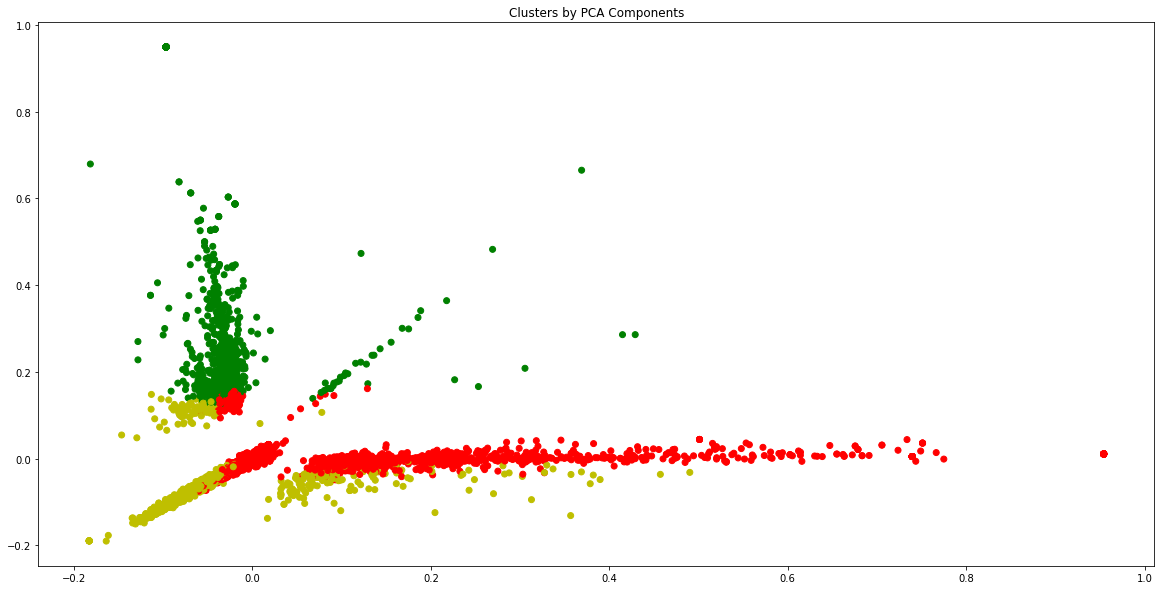

In [ ]:
colors = ["r", "g", "y" ]
x_axis = scatter_plot_points[:,0]
y_axis = scatter_plot_points[:,1]
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Clusters by PCA Components')
ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])
plt.show()


In [ ]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

terms = v.get_feature_names()
for i in range(3):
    print("Cluster %d:" % i)
    for j in sorted_centroids[i, :5]:
        print(' %s' % terms[j])
    print()

Cluster 0:
 you
 thank
 get
 service
 customer

Cluster 1:
 thanks
 great
 much
 flight
 got

Cluster 2:
 flight
 cancelled
 flightled
 delayed
 get



As we can see cluster 0 can represent positive sentiment, cluster 1 contains words with neutral tone and cluster 2 can be responsible for negative statements.